In [3]:
import os, sys, time, csv, logging
import numpy as np
from collections import deque
#import tensorflow as tf
from scipy import io as sio
import cv2
import traceback

import pandas as pd

import matplotlib.pyplot as plt

import tensorflow as tf

#from tensorflow.python.compiler.tensorrt import trt_convert as tf_trt
from tensorflow.python.saved_model import tag_constants
import tensorflow as tf
#import tensorrt as trt

from typing import List, Optional, Text, Tuple

from time import perf_counter

In [20]:
from teensy import Teensy

## Check timing

In [21]:
folder = 'test/2025_05_08_3'

behavior_times = pd.read_csv(os.path.join(folder, 'behavior_times.csv'))
process_times = pd.read_csv(os.path.join(folder, 'process_times.csv'))
cam_times_0 =  pd.read_csv(os.path.join(folder, 'Camera0', 'timestamps.csv'))
cam_times_1 =  pd.read_csv(os.path.join(folder, 'Camera1', 'timestamps.csv'))

In [33]:
behavior_times

,frameNumber,behaviorProcessTime,finalTimeStamp
0,0,0.011702,1.134243e+06
1,1,0.001318,1.134243e+06
2,2,0.001365,1.134243e+06
3,3,0.001338,1.134243e+06
4,4,0.001459,1.134243e+06
...,...,...,...
26996,26996,0.001296,1.136055e+06
26997,26997,0.001271,1.136055e+06
26998,26998,0.001376,1.136055e+06
26999,26999,0.001326,1.136055e+06


In [22]:
process_times

,frameNumber,timeStamp,frameProcessTime,LoadOnQueue
0,1,1.134243e+06,0.028609,0.000340
1,2,1.134243e+06,0.028438,0.000368
2,3,1.134243e+06,0.027141,0.000382
3,4,1.134243e+06,0.023337,0.000374
4,5,1.134243e+06,0.020863,0.000393
...,...,...,...,...
26995,26996,1.136055e+06,0.030674,0.000310
26996,26997,1.136055e+06,0.029225,0.000313
26997,26998,1.136055e+06,0.029157,0.000371
26998,26999,1.136055e+06,0.031416,0.000363


In [16]:
cam_times_1

,frameNumber,timeStamp,startTime,GrabTime,PreprocessTime,LoadOnWrite,ProcessQueueTimeStamp
0,1,534717.506320,1.062172e+06,0.003254,0.834342,0.000075,1.062173e+06
1,2,534717.556322,1.062173e+06,0.004238,0.020431,0.000056,1.062173e+06
2,3,534717.606325,1.062173e+06,0.000932,0.012953,0.000059,1.062173e+06
3,4,534717.656327,1.062173e+06,0.001230,0.012443,0.000029,1.062173e+06
4,5,534717.706330,1.062173e+06,0.000952,0.017477,0.000029,1.062173e+06
...,...,...,...,...,...,...,...
26995,26996,536414.345840,1.063877e+06,0.001135,0.085405,0.000042,1.063878e+06
26996,26997,536414.395843,1.063878e+06,0.001182,0.067044,0.000042,1.063878e+06
26997,26998,536414.495848,1.063878e+06,0.001003,0.072641,0.000052,1.063878e+06
26998,26999,536414.545851,1.063878e+06,0.001004,0.073098,0.000042,1.063878e+06


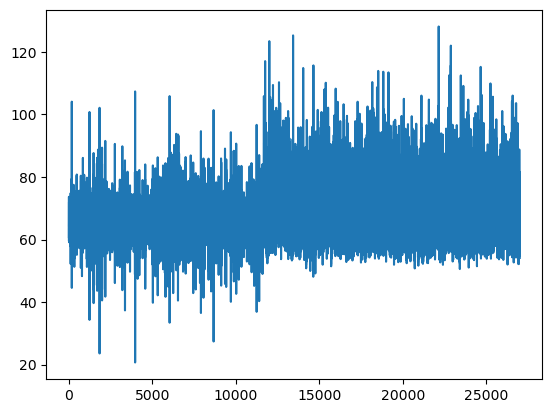

In [29]:
plt.plot(np.diff(cam_times_1['ProcessQueueTimeStamp'])*1000)

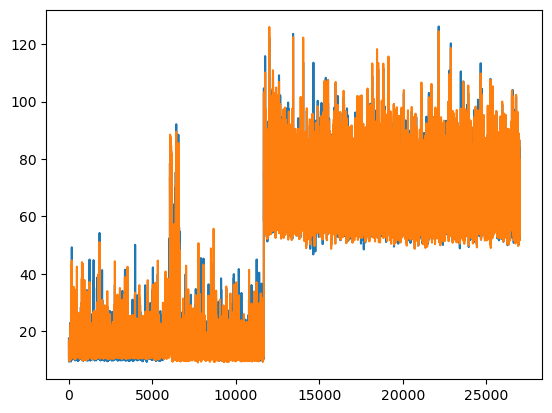

In [28]:
plt.plot(cam_times_1['PreprocessTime']*1000)
plt.plot(cam_times_0['PreprocessTime']*1000)

In [30]:
print(np.mean(cam_times_1['PreprocessTime'][15000:]*1000))

65.87087390273028


In [31]:
print(np.asarray(behavior_times['finalTimeStamp']-cam_times_1['startTime'])*1000)

[ -78.90991005    8.99618515    2.56635086 ... 1058.47040494 1019.10025487
           nan]


In [ ]:
plt.plot(np.asarray(behavior_times['finalTimeStamp']-cam_times_1['startTime'])*1000)

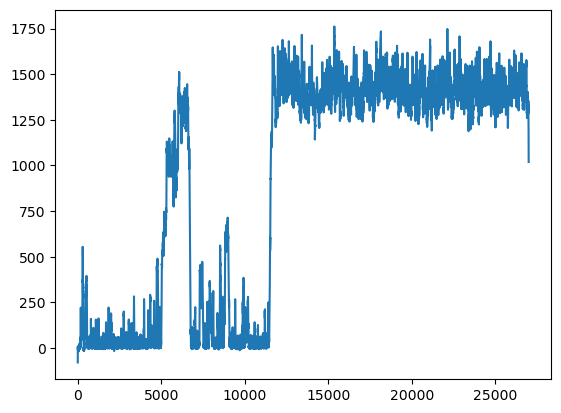

In [32]:
plt.plot(np.asarray(behavior_times['finalTimeStamp']-cam_times_1['startTime'])*1000)

In [25]:
process_times
print(np.asarray(process_times['frameProcessTime']*1000))
print(np.mean(np.asarray(process_times['frameProcessTime']*1000)))

[28.60888606 28.438068   27.14082319 ... 29.15740106 31.41602408
 33.39379909]
45.01869282108314


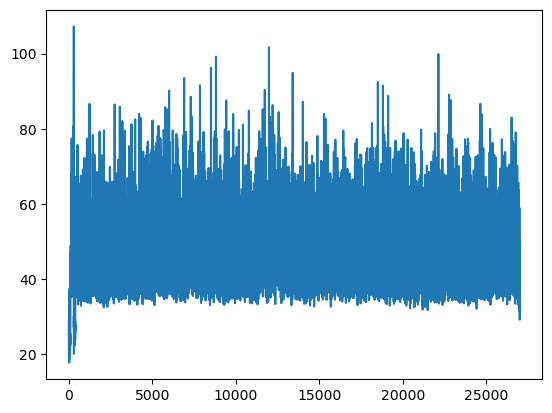

In [27]:
plt.plot(np.asarray(process_times['frameProcessTime']*1000))

In [24]:
finalTimeStamps = np.asarray(behavior_times['finalTimeStamp'])
print(np.diff(finalTimeStamps)*1000)
print(np.mean(np.diff(finalTimeStamps)*1000))

[153.11391302  59.43746585  62.47409107 ...  39.35505496  39.67767186
  43.29423816]
67.118438681372


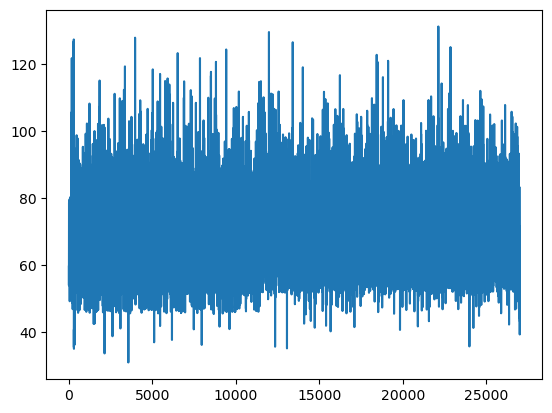

In [26]:
plt.plot(np.diff(finalTimeStamps[1:]*1000))

In [386]:
def read_frames(video_path, fidxs=None, grayscale=True):
    """Read frames from a video file.
    
    Args:
        video_path: Path to MP4
        fidxs: List of frame indices or None to read all frames (default: None)
        grayscale: Keep only one channel of the images (default: True)
    
    Returns:
        Loaded images in array of shape (n_frames, height, width, channels) and dtype uint8.
    """
    vr = cv2.VideoCapture(video_path)
    if fidxs is None:
        fidxs = np.arange(vr.get(cv2.CAP_PROP_FRAME_COUNT))
    frames = []
    for fidx in fidxs:
        vr.set(cv2.CAP_PROP_POS_FRAMES, fidx)
        img = vr.read()[1]
        if grayscale:
            img = img[:, :, [0]]
        frames.append(img)
    return np.stack(frames, axis=0)

## Compare img grab array to saved mp4 file content

In [387]:
framegrab = np.load('../campy/test/CamGrabSave.npy')
vidframe = read_frames('test/2025_05_01/Camera0/0.mp4', fidxs=[0], grayscale=False)

print(framegrab.shape)
print(vidframe.shape)

(1200, 1920, 3)
(1, 1200, 1920, 3)


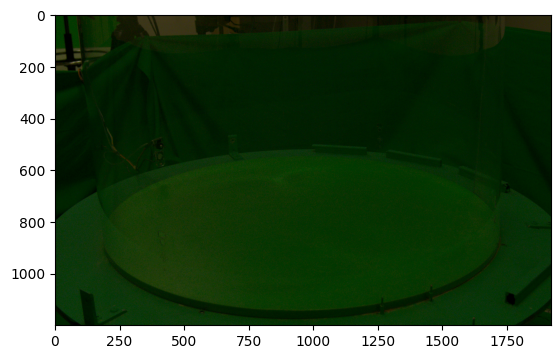

In [388]:
fig = plt.figure()

plt.imshow(framegrab, vmin=200)

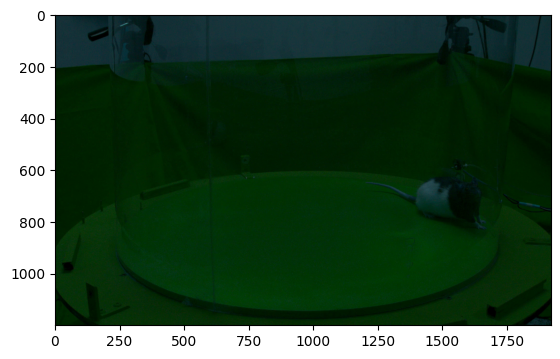

In [389]:
fig = plt.figure()
plt.imshow(np.squeeze(vidframe), vmin=200)

In [124]:
print(framegrab)

[[[ 0 59  0]
  [ 0 60  0]
  [ 0 61  0]
  ...
  [52 39 21]
  [52 44 12]
  [52 44 12]]

 [[ 0 58  0]
  [ 0 61  0]
  [ 0 58  0]
  ...
  [41 47 17]
  [43 44 13]
  [43 44 13]]

 [[ 4 56  0]
  [ 0 59  0]
  [ 0 54  0]
  ...
  [41 47 17]
  [43 43 21]
  [43 43 21]]

 ...

 [[ 0 38  0]
  [ 0 36  0]
  [ 0 36 11]
  ...
  [ 0 34  0]
  [ 0 34  0]
  [ 0 34  0]]

 [[ 0 36  0]
  [ 0 38  0]
  [ 0 38  0]
  ...
  [ 0 33  0]
  [ 0 34  0]
  [ 0 34  0]]

 [[ 0 36  0]
  [ 0 38  0]
  [ 0 38  0]
  ...
  [ 0 33  0]
  [ 0 34  0]
  [ 0 34  0]]]


In [129]:
print(np.mean(framegrab))
print(np.mean(vidframe[0]))


17.788169849537038
19.14336328125


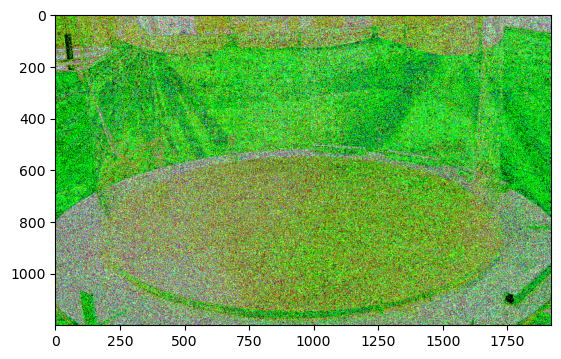

In [136]:
fig = plt.figure()

plt.imshow(vidframe[0]-framegrab)

In [5]:
def get_available_gpus() -> List[tf.config.PhysicalDevice]:
    """Return a list of available GPUs."""
    return tf.config.get_visible_devices("GPU")

def disable_preallocation():
    """Disable preallocation of full GPU memory on all available GPUs.

    This enables memory growth policy so that TensorFlow will not pre-allocate all
    available GPU memory.

    Preallocation can be more efficient, but can lead to CUDA startup errors when the
    memory is not available (e.g., shared, multi-session and some *nix systems).

    See also: enable_gpu_preallocation
    """
    for gpu in get_available_gpus():
        tf.config.experimental.set_memory_growth(gpu, True)

class OptimizedModel():
    def __init__(self, saved_model_dir = None):
        self.loaded_model_fn = None
        
        if not saved_model_dir is None:
            self.load_model(saved_model_dir)
            
    
    def predict(self, input_data, batch_size=None): 
        if self.loaded_model_fn is None:
            raise(Exception("Haven't loaded a model"))
            
        if batch_size is not None:
            all_inds = np.arange(len(input_data))
            all_preds = []
            for inds in np.array_split(all_inds, int(np.ceil(len(all_inds) / batch_size))):
                all_preds.append(self.predict(input_data[inds]))
            return all_preds
                
#         x = tf.constant(input_data.astype('float32'))
        x = tf.constant(input_data)
        labeling = self.loaded_model_fn(input=x)
        try:
            preds = labeling['predictions'].numpy()
        except:
            try:
                preds = labeling['probs'].numpy()
            except:
                try:
                    preds = labeling[next(iter(labeling.keys()))]
                except:
                    raise(Exception("Failed to get predictions from saved model object"))
        return preds
    
    def load_model(self, saved_model_dir):
        saved_model_loaded = tf.saved_model.load(saved_model_dir, tags=[tag_constants.SERVING])
        wrapper_fp32 = saved_model_loaded.signatures['serving_default']
        
        self.loaded_model_fn = wrapper_fp32

In [6]:
def normalize_bboxes(
    bboxes: tf.Tensor, image_height: int, image_width: int
) -> tf.Tensor:
    """Normalize bounding box coordinates to the range [0, 1].

    This is useful for transforming points for TensorFlow operations that require
    normalized image coordinates.

    Args:
        bboxes: Tensor of shape (n_bboxes, 4) and dtype tf.float32, where the last axis
            corresponds to (y1, x1, y2, x2) coordinates of the bounding boxes.
        image_height: Scalar integer indicating the height of the image.
        image_width: Scalar integer indicating the width of the image.

    Returns:
        Tensor of the normalized points of the same shape as `bboxes`.

        The normalization applied to each point is `x / (image_width - 1)` and
        `y / (image_width - 1)`.

    See also: unnormalize_bboxes
    """
    # Compute normalizing factor of shape (1, 4).
    factor = (
        tf.convert_to_tensor(
            [[image_height, image_width, image_height, image_width]], tf.float32
        )
        - 1
    )

    # Normalize and return.
    normalized_bboxes = bboxes / factor
    return normalized_bboxes

In [7]:
def find_padding_for_stride(
    image_height: int, image_width: int, max_stride: int
) -> Tuple[int, int]:
    """Compute padding required to ensure image is divisible by a stride.

    This function is useful for determining how to pad images such that they will not
    have issues with divisibility after repeated pooling steps.

    Args:
        image_height: Scalar integer specifying the image height (rows).
        image_width: Scalar integer specifying the image height (columns).
        max_stride: Scalar integer specifying the maximum stride that the image must be
            divisible by.

    Returns:
        A tuple of (pad_bottom, pad_right), integers with the number of pixels that the
        image would need to be padded by to meet the divisibility requirement.
    """
    # The outer-most modulo handles edge case when image_height % max_stride == 0
    pad_bottom = (max_stride - (image_height % max_stride)) % max_stride
    pad_right = (max_stride - (image_width % max_stride)) % max_stride
    return pad_bottom, pad_right


@tf.function
def pad_to_stride(image: tf.Tensor, max_stride: int) -> tf.Tensor:
    """Pad an image to meet a max stride constraint.

    This is useful for ensuring there is no size mismatch between an image and the
    output tensors after multiple downsampling and upsampling steps.

    Args:
        image: Single image tensor of shape (height, width, channels).
        max_stride: Scalar integer specifying the maximum stride that the image must be
            divisible by. This is the ratio between the length of the image and the
            length of the smallest tensor it is converted to. This is typically
            `2 ** n_down_blocks`, where `n_down_blocks` is the number of 2-strided
            reduction layers in the model.

    Returns:
        The input image with 0-padding applied to the bottom and/or right such that the
        new shape's height and width are both divisible by `max_stride`.
    """
    pad_bottom, pad_right = find_padding_for_stride(
        image_height=tf.shape(image)[-3],
        image_width=tf.shape(image)[-2],
        max_stride=max_stride,
    )
    if pad_bottom > 0 or pad_right > 0:
        if tf.rank(image) == 3:
            paddings = tf.cast([[0, pad_bottom], [0, pad_right], [0, 0]], tf.int32)
        else:
            # tf.rank(image) == 4:
            paddings = tf.cast(
                [[0, 0], [0, pad_bottom], [0, pad_right], [0, 0]], tf.int32
            )

        image = tf.pad(image, paddings, mode="CONSTANT", constant_values=0)
    return image

In [8]:
def make_centered_bboxes(
    centroids: tf.Tensor, box_height: int, box_width: int
) -> tf.Tensor:
    """Generate bounding boxes centered on a set of centroid coordinates.

    Args:
        centroids: A tensor of shape (n_centroids, 2) and dtype tf.float32, where the
            last axis corresponds to the (x, y) coordinates of each centroid.
        box_height: Scalar integer indicating the height of the bounding boxes.
        box_width: Scalar integer indicating the width of the bounding boxes.

    Returns:
        Tensor of shape (n_centroids, 4) and dtype tf.float32, where the last axis
        corresponds to (y1, x1, y2, x2) coordinates of the bounding boxes in absolute
        image coordinates.

    Notes:
        The bounding box coordinates are calculated such that the centroid coordinates
        map onto the center of the pixel. For example:

        For a single row image of shape (1, 4) with values: `[[a, b, c, d]]`, the x
        coordinates can be visualized in the diagram below:
                 _______________________
                |  a  |  b  |  c  |  d  |
                |  |  |  |  |  |  |  |  |
              -0.5 | 0.5 | 1.5 | 2.5 | 3.5
                   0     1     2     3

        To get a (1, 3) patch centered at c, the centroid would be at (x, y) = (2, 0)
        with box height of 1 and box width of 3, to yield `[[b, c, d]]`.

        For even sized bounding boxes, e.g., to get the center 2 elements, the centroid
        would be at (x, y) = (1.5, 0) with box width of 2, to yield `[[b, c]]`.
    """
    delta = (
        tf.convert_to_tensor(
            [[-box_height + 1, -box_width + 1, box_height - 1, box_width - 1]],
            tf.float32,
        )
        * 0.5
    )
    bboxes = tf.gather(centroids, [1, 0, 1, 0], axis=-1) + delta
    return bboxes

In [9]:
def find_offsets_local_direction(
    centered_patches: tf.Tensor, delta: float = 0.25
) -> tf.Tensor:
    """Computes subpixel offsets from the direction of the pixels around the peak.

    This function finds the delta-offset from the center pixel of peak-centered patches
    by finding the direction of the gradient around each center.

    Args:
        centered_patches: A rank-4 tensor of shape (samples, 3, 3, 1) corresponding
            to the centered crops around the grid-anchored peaks. For multi-channel
            images, stack the channels along the samples axis before calling this
            function.
        delta: Scalar float that will scaled by the gradient direction.

    Returns:
        offsets, a float32 tensor of shape (samples, 2) where the columns correspond to
        the offsets relative to the center pixel for the x and y directions
        respectively, i.e., for the i-th sample:

            dx_i, dy_i = offsets[i]

    Notes:
        For symmetric patches, the offset will be 0.

        This function can be used to refine peak coordinates by:
            1. Cropping 3 x 3 patches around each peak.
            2. Stacking patches along the samples axis.
            3. Computing the local gradient around each centered patch.
            4. Applying subpixel offsets to each peak.

        This is a commonly used algorithm for subpixel peak refinement, described for
        pose estimation applications in [1].

    Example: ::

        >>> find_offsets_local_direction(np.array(
        ...     [[0., 1., 0.],
        ...      [1., 3., 2.],
        ...      [0., 1., 0.]]).reshape(1, 3, 3, 1), 0.25)
        <tf.Tensor: shape=(1, 2), dtype=float64, numpy=array([[0.25, 0.  ]])>

    References:
        .. [1] Alejandro Newell, Kaiyu Yang, and Jia Deng. Stacked Hourglass Networks
           for Human Pose Estimation. In _European conference on computer vision_, 2016.
    """

    # Compute directional gradients.
    dx = centered_patches[:, 1, 2, :] - centered_patches[:, 1, 0, :]  # right - left
    dy = centered_patches[:, 2, 1, :] - centered_patches[:, 0, 1, :]  # bottom - top

    # Concatenate and scale signed direction by delta.
    offsets = tf.sign(tf.squeeze(tf.stack([dx, dy], axis=1), axis=-1)) * delta

    return offsets


def crop_bboxes(
    images: tf.Tensor, bboxes: tf.Tensor, sample_inds: tf.Tensor
) -> tf.Tensor:
    """Crop bounding boxes from a batch of images.

    This method serves as a convenience method for specifying the arguments of
    `tf.image.crop_and_resize`.

    Args:
        images: Tensor of shape (samples, height, width, channels) of a batch of images.
        bboxes: Tensor of shape (n_bboxes, 4) and dtype tf.float32, where the last axis
            corresponds to unnormalized (y1, x1, y2, x2) coordinates of the bounding
            boxes. This can be generated from centroids using `make_centered_bboxes`.
        sample_inds: Tensor of shape (n_bboxes,) specifying which samples each bounding
            box should be cropped from.

    Returns:
        A tensor of shape (n_bboxes, crop_height, crop_width, channels) of the same
        dtype as the input image. The crop size is inferred from the bounding box
        coordinates.

    Notes:
        This function expects bounding boxes with coordinates at the centers of the
        pixels in the box limits. Technically, the box will span (x1 - 0.5, x2 + 0.5)
        and (y1 - 0.5, y2 + 0.5).

        For example, a 3x3 patch centered at (1, 1) would be specified by
        (y1, x1, y2, x2) = (0, 0, 2, 2). This would be exactly equivalent to indexing
        the image with `image[0:3, 0:3]`.

    See also: `make_centered_bboxes`
    """
    # Compute bounding box size to use for crops.
    y1x1 = tf.gather_nd(bboxes, [[0, 0], [0, 1]])
    y2x2 = tf.gather_nd(bboxes, [[0, 2], [0, 3]])
    box_size = tf.cast(tf.math.round((y2x2 - y1x1) + 1), tf.int32)  # (height, width)

    # Normalize bounding boxes.
    image_height = tf.shape(images)[1]
    image_width = tf.shape(images)[2]
    normalized_bboxes = normalize_bboxes(
        bboxes, image_height=image_height, image_width=image_width
    )

    # Crop.
    crops = tf.image.crop_and_resize(
        images,
        boxes=normalized_bboxes,
        box_indices=tf.cast(sample_inds, tf.int32),
        crop_size=box_size,
        method="bilinear",
    )

    # Cast back to original dtype and return.
    crops = tf.cast(crops, images.dtype)
    return crops

In [10]:
def integral_regression(
    cms: tf.Tensor, xv: tf.Tensor, yv: tf.Tensor
) -> Tuple[tf.Tensor, tf.Tensor]:
    """Compute regression by integrating over the confidence maps on a grid.

    Args:
        cms: Confidence maps with shape (samples, height, width, channels).
        xv: X grid vector tf.float32 of grid coordinates to sample.
        yv: Y grid vector tf.float32 of grid coordinates to sample.

    Returns:
        A tuple of (x_hat, y_hat) with the regressed x- and y-coordinates for each
        channel of the confidence maps.

        x_hat and y_hat are of shape (samples, channels)
    """
    # Compute normalizing factor.
    z = tf.reduce_sum(cms, axis=[1, 2])

    # Regress to expectation.
    x_hat = tf.reduce_sum(tf.reshape(xv, [1, 1, -1, 1]) * cms, axis=[1, 2]) / z
    y_hat = tf.reduce_sum(tf.reshape(yv, [1, -1, 1, 1]) * cms, axis=[1, 2]) / z

    return x_hat, y_hat

In [11]:
def find_global_peaks_rough(
    cms: tf.Tensor, threshold: float = 0.1
) -> Tuple[tf.Tensor, tf.Tensor]:
    """Find the global maximum for each sample and channel.

    Args:
        cms: Tensor of shape (samples, height, width, channels).
        threshold: Scalar float specifying the minimum confidence value for peaks. Peaks
            with values below this threshold will be replaced with NaNs.

    Returns:
        A tuple of (peak_points, peak_vals).

        peak_points: float32 tensor of shape (samples, channels, 2), where the last axis
        indicates peak locations in xy order.

        peak_vals: float32 tensor of shape (samples, channels) containing the values at
        the peak points.
    """
    # Find row maxima.
    max_img_rows = tf.reduce_max(cms, axis=2)
    argmax_rows = tf.reshape(tf.argmax(max_img_rows, axis=1), [-1])

    # Find col maxima.
    max_img_cols = tf.reduce_max(cms, axis=1)
    argmax_cols = tf.reshape(tf.argmax(max_img_cols, axis=1), [-1])

    # Construct sample and channel subscripts.
    channels = tf.cast(tf.shape(cms)[-1], tf.int64)
    total_peaks = tf.cast(tf.shape(argmax_cols)[0], tf.int64)
    sample_subs = tf.range(total_peaks, dtype=tf.int64) // channels
    channel_subs = tf.math.mod(tf.range(total_peaks, dtype=tf.int64), channels)

    # Gather subscripts.
    peak_subs = tf.stack([sample_subs, argmax_rows, argmax_cols, channel_subs], axis=1)

    # Gather values at global maxima.
    peak_vals = tf.gather_nd(cms, peak_subs)

    # Convert to points form (samples, channels, 2).
    peak_points = tf.reshape(
        tf.cast(tf.stack([argmax_cols, argmax_rows], axis=-1), tf.float32),
        [-1, channels, 2],
    )
    peak_vals = tf.reshape(peak_vals, [-1, channels])

    # Mask out low confidence points.
    peak_points = tf.where(
        tf.expand_dims(peak_vals, axis=-1) < threshold,
        x=tf.constant(np.nan, dtype=tf.float32),
        y=peak_points,
    )

    return peak_points, peak_vals

@tf.function
def find_global_peaks(
    cms: tf.Tensor,
    threshold: float = 0.2,
    refinement: Optional[str] = None,
    integral_patch_size: int = 5,
) -> Tuple[tf.Tensor, tf.Tensor]:
    """Find global peaks with optional refinement.

    Args:
        cms: Confidence maps. Tensor of shape (samples, height, width, channels).
        threshold: Minimum confidence threshold. Peaks with values below this will
            ignored.
        refinement: If `None`, returns the grid-aligned peaks with no refinement. If
            `"integral"`, peaks will be refined with integral regression. If `"local"`,
            peaks will be refined with quarter pixel local gradient offset.
        integral_patch_size: Size of patches to crop around each rough peak as an
            integer scalar.

    Returns:
        A tuple of (peak_points, peak_vals).

        peak_points: float32 tensor of shape (samples, channels, 2), where the last axis
        indicates peak locations in xy order.

        peak_vals: float32 tensor of shape (samples, channels) containing the values at
        the peak points.
    """
    # Find grid aligned peaks.
    rough_peaks, peak_vals = find_global_peaks_rough(
        cms, threshold=threshold
    )  # (samples, channels, 2)

    # Return early if not refining or no rough peaks found.
    if refinement is None or tf.reduce_all(tf.math.is_nan(rough_peaks)):
        return rough_peaks, peak_vals

    if refinement == "integral":
        crop_size = integral_patch_size
    elif refinement == "local":
        crop_size = 3
    else:
        return rough_peaks, peak_vals

    # Flatten samples and channels to (n_peaks, 2).
    samples = tf.shape(cms)[0]
    channels = tf.shape(cms)[3]
    rough_peaks = tf.reshape(rough_peaks, [samples * channels, 2])

    # Keep only peaks that are not NaNs.
    valid_idx = tf.squeeze(
        tf.where(~tf.math.is_nan(tf.gather(rough_peaks, 0, axis=1))), axis=1
    )
    valid_peaks = tf.gather(rough_peaks, valid_idx, axis=0)

    # Make bounding boxes for cropping around peaks.
    bboxes = make_centered_bboxes(
        valid_peaks, box_height=crop_size, box_width=crop_size
    )

    # Crop patch around each grid-aligned peak.
    cms = tf.reshape(
        tf.transpose(cms, [0, 3, 1, 2]),
        [samples * channels, tf.shape(cms)[1], tf.shape(cms)[2], 1],
    )
    cm_crops = crop_bboxes(cms, bboxes, sample_inds=valid_idx)

    # Compute offsets via integral regression on a local patch.
    if refinement == "integral":
        gv = tf.cast(tf.range(crop_size), tf.float32) - ((crop_size - 1) / 2)
        dx_hat, dy_hat = integral_regression(cm_crops, xv=gv, yv=gv)
        offsets = tf.concat([dx_hat, dy_hat], axis=1)
    else:
        offsets = find_offsets_local_direction(cm_crops, 0.25)

    # Apply offsets.
    refined_peaks = tf.tensor_scatter_nd_add(
        rough_peaks, tf.expand_dims(valid_idx, axis=1), offsets
    )

    # Reshape to (samples, channels, 2).
    refined_peaks = tf.reshape(refined_peaks, [samples, channels, 2])

    return refined_peaks, peak_vals

In [18]:
%%writefile benchmark_model.py

import os, sys, time, csv, logging
import numpy as np
from collections import deque
#import tensorflow as tf
from scipy import io as sio
import cv2
import traceback

import tensorflow as tf
import tensorrt 

from tensorflow.python.compiler.tensorrt import trt_convert as tf_trt
from tensorflow.python.saved_model import tag_constants
from typing import List, Optional, Text

from time import perf_counter

def read_frames(video_path, fidxs=None, grayscale=True):
    """Read frames from a video file.
    
    Args:
        video_path: Path to MP4
        fidxs: List of frame indices or None to read all frames (default: None)
        grayscale: Keep only one channel of the images (default: True)
    
    Returns:
        Loaded images in array of shape (n_frames, height, width, channels) and dtype uint8.
    """
    vr = cv2.VideoCapture(video_path)
    if fidxs is None:
        fidxs = np.arange(vr.get(cv2.CAP_PROP_FRAME_COUNT))
    frames = []
    for fidx in fidxs:
        vr.set(cv2.CAP_PROP_POS_FRAMES, fidx)
        img = vr.read()[1]
        if grayscale:
            img = img[:, :, [0]]
        frames.append(img)
    return np.stack(frames, axis=0)

def get_available_gpus() -> List[tf.config.PhysicalDevice]:
    """Return a list of available GPUs."""
    return tf.config.get_visible_devices("GPU")

def disable_preallocation():
    """Disable preallocation of full GPU memory on all available GPUs.

    This enables memory growth policy so that TensorFlow will not pre-allocate all
    available GPU memory.

    Preallocation can be more efficient, but can lead to CUDA startup errors when the
    memory is not available (e.g., shared, multi-session and some *nix systems).

    See also: enable_gpu_preallocation
    """
    for gpu in get_available_gpus():
        tf.config.experimental.set_memory_growth(gpu, True)

class OptimizedModel():
    def __init__(self, saved_model_dir = None):
        self.loaded_model_fn = None
        
        if not saved_model_dir is None:
            self.load_model(saved_model_dir)
            
    
    def predict(self, input_data, batch_size=None): 
        if self.loaded_model_fn is None:
            raise(Exception("Haven't loaded a model"))
            
        if batch_size is not None:
            all_inds = np.arange(len(input_data))
            all_preds = []
            for inds in np.array_split(all_inds, int(np.ceil(len(all_inds) / batch_size))):
                all_preds.append(self.predict(input_data[inds]))
            return all_preds
                
#         x = tf.constant(input_data.astype('float32'))
        x = tf.constant(input_data)
        labeling = self.loaded_model_fn(input=x)
        try:
            preds = labeling['predictions'].numpy()
        except:
            try:
                preds = labeling['probs'].numpy()
            except:
                try:
                    preds = labeling[next(iter(labeling.keys()))]
                except:
                    raise(Exception("Failed to get predictions from saved model object"))
        return preds
    
    def load_model(self, saved_model_dir):
        saved_model_loaded = tf.saved_model.load(saved_model_dir, tags=[tag_constants.SERVING])
        wrapper_fp32 = saved_model_loaded.signatures['serving_default']
        
        self.loaded_model_fn = wrapper_fp32

if __name__ == '__main__':

    model_path = '../models/250421_183045.single_instance.n=8280.trt.FP32'
    model = OptimizedModel(model_path)
    
    video_path = '../test/example.mp4'
    
    t0 = perf_counter()
    
    frame = read_frames(video_path, fidxs=[0], grayscale=False)
    
    t1 = perf_counter()
    
    with tf.device('/CPU:0'):
        imresized = tf.transpose(tf.cast(tf.image.resize(frame, size=[600,960], method='bilinear', preserve_aspect_ratio=False, antialias=False,), tf.float32), perm=[0,3,1,2])
    #ready for processing 

    print(imresized.device)
    
    t2 = perf_counter()
    
    #disable_preallocation()
    
    with tf.device('/GPU:0'):
        gpu_tensor = tf.cast(tf.Variable(initial_value=tf.zeros((3,3,600,960))), tf.float32)
    
    model.predict(gpu_tensor) #initialize graph 
    
    t3 = perf_counter()
    
    for i in range(3):
        gpu_tensor[i].assign(imresized) # check how long to load frames onto GPU

    print(gpu_tensor.device)
    
    t4 = perf_counter()
    
    output = model.predict(gpu_tensor)
    
    t5 = perf_counter()
    
    print(f'Read frame time: {(t1-t0)*1000} msec')
    print(f'CPU im preprocessing time: {(t2-t1)*1000} msec')
    print(f'Model and gpu tensor initialization time: {(t3-t2)*1000} msec')
    print(f'Place preprocessed frames on GPU time: {(t4-t3)*1000} msec')
    print(f'Model prediction time: {(t5-t4)*1000} msec')

Overwriting benchmark_model.py


In [23]:
!python benchmark_model.py

2025-04-22 13:28:30.342353: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/job:localhost/replica:0/task:0/device:CPU:0
/job:localhost/replica:0/task:0/device:GPU:0
Read frame time: 156.14230604842305 msec
CPU im preprocessing time: 21.084015956148505 msec
Model and gpu tensor initialization time: 18307.431894005276 msec
Place preprocessed frames on GPU time: 17.467250989284366 msec
Model prediction time: 22.711958037689328 msec


## Convert model output to keypoints: peak finding

In [12]:
def scale_image_range(image, min_val, max_val):
    return (image*(max_val-min_val)+min_val)

In [13]:
def convert_rgb_to_bgr(image: tf.Tensor) -> tf.Tensor:
    """Convert an RGB image to BGR format by reversing the channel order.

    Args:
        image: Tensor of any dtype with shape (..., 3) in RGB format. If grayscale, the
            image will be converted to RGB first.

    Returns:
        The input image with the channels axis reversed.
    """
    return tf.reverse(image, axis=[-1])

In [14]:
def resize_image(image: tf.Tensor, scale: tf.Tensor) -> tf.Tensor:
    """Rescale an image by a scale factor.

    This function is primarily a convenience wrapper for `tf.image.resize` that
    calculates the new shape from the scale factor.

    Args:
        image: Single image tensor of shape (height, width, channels).
        scale: Factor to resize the image dimensions by, specified as either a float
            scalar or as a 2-tuple of [scale_x, scale_y]. If a scalar is provided, both
            dimensions are resized by the same factor.

    Returns:
        The resized image tensor of the same dtype but scaled height and width.

    See also: tf.image.resize
    """
    height = tf.shape(image)[-3]
    width = tf.shape(image)[-2]
    new_size = tf.reverse(
        tf.cast(
            tf.cast([width, height], tf.float32) * tf.cast(scale, tf.float32), tf.int32
        ),
        [0],
    )
    return tf.cast(
        tf.image.resize(
            image,
            size=new_size,
            method="bilinear",
            preserve_aspect_ratio=False,
            antialias=False,
        ),
        image.dtype,
    )

In [361]:
model_path = '../campy/models/250421_183045.single_instance.n=8280.trt.FP32'
model = OptimizedModel(model_path)

In [403]:
def get_peaks(model, video_path):
    num_frames = 100
    peaks_all = np.zeros((num_frames, 23, 2))
    peak_vals_all = np.zeros((num_frames,23))

    frame_number = 0 

    for i in range(num_frames):
        
        frame = read_frames(video_path, fidxs=[frame_number], grayscale=False) #batchxheightxwidthxchannel
        #with tf.device('/CPU:0'):
            #frame_use = frame/255
            #frame_use = tf.image.convert_image_dtype(grabResult.Array, tf.float32)
        #    imresized = tf.cast(tf.image.resize(frame, size=[600,960], method='bilinear', preserve_aspect_ratio=False, antialias=False,), frame.dtype)
        #	imresized = resize_image(img, 0.5)
        #    imtranspose = tf.transpose(imresized, perm=[0,3,1,2])
        #    imbgr = convert_rgb_to_bgr(imtranspose)

        #imuse = tf.image.convert_image_dtype(imbgr, tf.float32)

        #output = model.predict(imuse)

        with tf.device('/CPU:0'):
            #imresized = resize_image(frame, 0.5)
            imresized = tf.cast(tf.image.resize(frame, size=[600,960], method='bilinear', preserve_aspect_ratio=False, antialias=False,), frame.dtype)
            imresized = convert_rgb_to_bgr(imresized)
            imresized = tf.transpose(imresized, perm=[0,3,1,2])
            imresized = tf.image.convert_image_dtype(imresized, tf.float32)

            
        #imrev = tf.reverse(imresized, 1)

        output = model.predict(imresized)

        trans_output = tf.transpose(output, perm=[0,2,3,1])

        peaks, peak_vals = find_global_peaks_rough(trans_output) #peaks: 3x2x23

        peaks = peaks * 8
        #peaks = (peaks / 0.5) + 0.5

        peaks_all[i,:,:] = peaks
        peak_vals_all[i,:] = peak_vals

        frame_number+=1

    return peaks_all, peak_vals_all
    

In [404]:
video_path = 'test/2025_05_01/Camera0/0.mp4'
sleap_out = np.load('test/2025_05_01/sleap_keys_2D.npy')
cam_params = sio.loadmat('extrinsics/2025_04_30_2cam_calibration/hires_cam7_params.mat', simplify_cells=True)
K = cam_params['K']
rdist = cam_params['RDistort']
tdist = cam_params['TDistort']
dist_coefs = np.asarray([rdist[0],rdist[1],tdist[0],tdist[1]])
#params = sio.loadmat(f'data/2022_10_10_M1/calibration/hires_cam{cam+1}_params.mat', simplify_cells=True)

#cam_params[cam+1] = {'K':params['K'], 'RDistort':params['RDistort'], 'TDistort':params['TDistort'], 'r':params['r'], 't':params['t']}
peaks_all, peak_vals_all = get_peaks(model, video_path)

np.save('test/2025_05_01/offline_sleap_2D_cam0.npy', peaks_all)

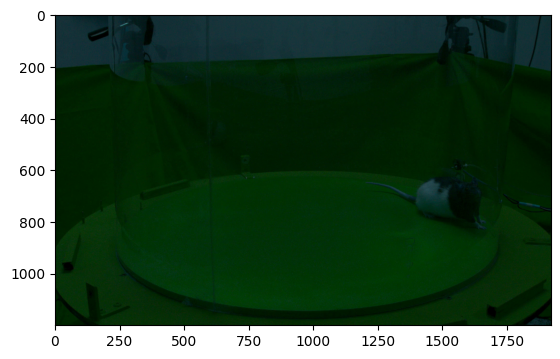

In [393]:
frame = read_frames(video_path, fidxs=np.arange(10), grayscale=False) #batchxheightxwidthxchannel

plt.imshow(np.squeeze(frame[0]))

In [394]:
print(peaks_all.shape)
print(sleap_out.shape)
sleap_peaks = np.transpose(sleap_out[:100,:,:,0],[0,2,1])
print(sleap_peaks.shape)
frame = read_frames(video_path, fidxs=np.arange(10), grayscale=False) #batchxheightxwidthxchannel
#vid_path1 = 'test/2025_05_01/Camera1/0.mp4'
#frame1 = read_frames(vid_path1, fidxs=np.arange(10), grayscale=False)

(10, 23, 2)
(4500, 2, 23, 3)
(100, 23, 2)


In [395]:
def undistort_points(points, K, dist_coeffs):
    """
    points: (N,2) array of pixel coordinates in one image
    K: (3,3) intrinsic matrix
    dist_coeffs: vector [k1,k2,p1,p2,(k3,…)] as OpenCV expects
    returns: (N,2) of normalized coordinates x',y' satisfying
             [x', y', 1]^T ∝ K^{-1} [u,v,1]^T after removing distortion
    """
    # OpenCV’s undistortPoints returns normalized coordinates if you omit P
    pts = points.reshape(-1,1,2).astype(np.float64)
    undist = cv2.undistortPoints(pts, K, dist_coeffs)  
    return undist.reshape(-1,2)



In [396]:
def plot_keypoints_2D(frame, keypoints, edges, bgr=False): #keypoints should be num_keypoints x 2
    fig = plt.figure()

    if bgr:
        frame = convert_rgb_to_bgr(frame)

    #keys_to_plot = np.zoer

    #keypoints = np.flip(keypoints,axis=1)

    plt.imshow(np.squeeze(frame))
    
    plt.scatter(keypoints[:,0], keypoints[:,1], c='red', marker='o')
    for edge in edges:
        start = keypoints[edge[0],:]
        end = keypoints[edge[1],:]
        plt.plot([start[0], end[0]], [start[1],end[1]], 'k-', lw=2)
    
    #plt.axis('off')
    plt.show()
    

(23, 2)
(23, 2)


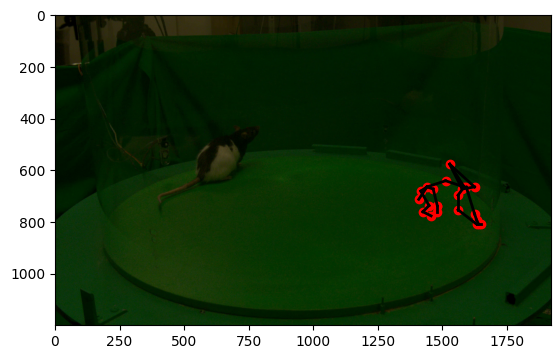

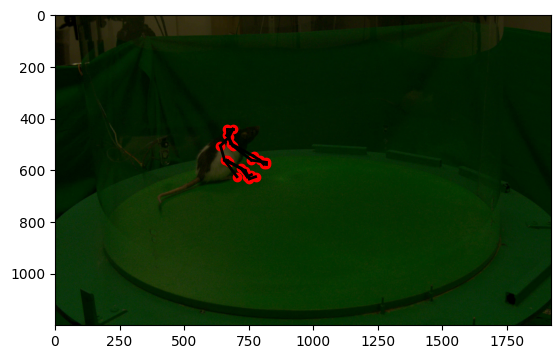

In [405]:
print(sleap_peaks[0].shape)
print(peaks_all[0].shape)
sleap_undistort = undistort_points(sleap_peaks[0], K, dist_coefs)
plot_keypoints_2D(frame[0], peaks_all[0], edges, bgr=True)
plot_keypoints_2D(frame[0], sleap_peaks[0], edges, bgr=True)

In [406]:
video_path = 'test/2025_05_01/Camera1/0.mp4'
sleap_out = np.load('test/2025_05_01/sleap_keys_2D.npy')
cam_params = sio.loadmat('extrinsics/2025_04_30_2cam_calibration/hires_cam7_params.mat', simplify_cells=True)
K = cam_params['K']
rdist = cam_params['RDistort']
tdist = cam_params['TDistort']
dist_coefs = np.asarray([rdist[0],rdist[1],tdist[0],tdist[1]])
#params = sio.loadmat(f'data/2022_10_10_M1/calibration/hires_cam{cam+1}_params.mat', simplify_cells=True)

#cam_params[cam+1] = {'K':params['K'], 'RDistort':params['RDistort'], 'TDistort':params['TDistort'], 'r':params['r'], 't':params['t']}
peaks_all, peak_vals_all = get_peaks(model, video_path)
np.save('test/2025_05_01/offline_sleap_2D_cam1.npy', peaks_all)

In [399]:
print(peaks_all.shape)
print(sleap_out.shape)
sleap_peaks = np.transpose(sleap_out[:100,:,:,1],[0,2,1])
print(sleap_peaks.shape)
frame = read_frames(video_path, fidxs=np.arange(10), grayscale=False) #batchxheightxwidthxchannel
#vid_path1 = 'test/2025_05_01/Camera1/0.mp4'
#frame1 = read_frames(vid_path1, fidxs=np.arange(10), grayscale=False)

(10, 23, 2)
(4500, 2, 23, 3)
(100, 23, 2)


(23, 2)
(23, 2)


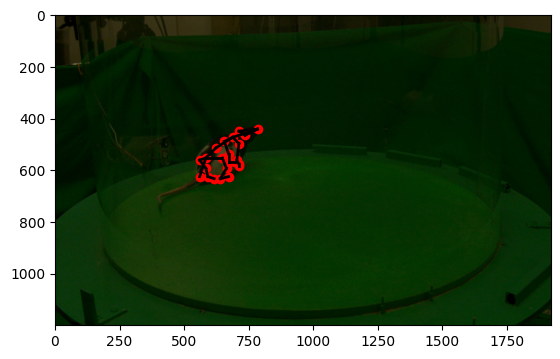

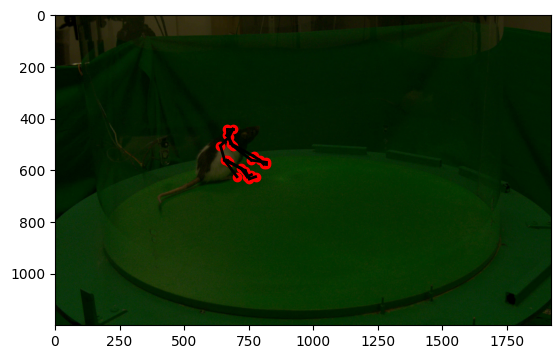

In [400]:
print(sleap_peaks[0].shape)
print(peaks_all[0].shape)
sleap_undistort = undistort_points(sleap_peaks[0], K, dist_coefs)
plot_keypoints_2D(frame[0], peaks_all[0], edges, bgr=True)
plot_keypoints_2D(frame[0], sleap_peaks[0], edges, bgr=True)

In [281]:
fig = plt.figure()

plt.scatter(to_plot[:,0], to_plot[:,1])
for edge in edges:

    start = to_plot[edge[0],:]
    end = to_plot[edge[1],:]
    plt.plot([start[0], end[0]], [start[1],end[1]], 'k-', lw=2)
plt.show()

NameError: name 'to_plot' is not defined

<Figure size 640x480 with 0 Axes>

In [ ]:
video_path = '../../CLIRB/data/vidSavesSLP/ARID1B_WK1_2022_10_10_M1_mov.mp4'

peaks_all, peak_vals_all = get_peaks(model, video_path)

out_dict = {'peaks': peaks_all, 'peak_vals':peak_vals_all}
np.savez('../../CLIRB/data/example_2D_outputs/ARID1B_WK1_2022_10_10_M1_points.npz', peaks=peaks_all, peak_vals = peak_vals_all)

In [61]:
video_path = '../../CLIRB/data/vidSavesSLP/ARID1B_WK1_2022_10_10_M2_mov.mp4'

peaks_all, peak_vals_all = get_peaks(model, video_path)

out_dict = {'peaks': peaks_all, 'peak_vals':peak_vals_all}
np.savez('../../CLIRB/data/example_2D_outputs/ARID1B_WK1_2022_10_10_M2_points.npz', peaks=peaks_all, peak_vals = peak_vals_all)

In [62]:
video_path = '../../CLIRB/data/vidSavesSLP/ARID1B_WK1_2022_10_10_M3_mov.mp4'

peaks_all, peak_vals_all = get_peaks(model, video_path)

out_dict = {'peaks': peaks_all, 'peak_vals':peak_vals_all}
np.savez('../../CLIRB/data/example_2D_outputs/ARID1B_WK1_2022_10_10_M3_points.npz', peaks=peaks_all, peak_vals = peak_vals_all)

In [63]:
video_path = '../../CLIRB/data/vidSavesSLPtest/SCN2A_WK1_2022_09_15_M2_mov.mp4'

peaks_all, peak_vals_all = get_peaks(model, video_path)

out_dict = {'peaks': peaks_all, 'peak_vals':peak_vals_all}
np.savez('../../CLIRB/data/example_2D_outputs/SCN2A_WK1_2022_09_15_M2_mov_points.npz', peaks=peaks_all, peak_vals = peak_vals_all)

In [64]:
video_path = '../../CLIRB/data/vidSavesSLPtest/SCN2A_WK1_2022_09_15_M3_mov.mp4'

peaks_all, peak_vals_all = get_peaks(model, video_path)

out_dict = {'peaks': peaks_all, 'peak_vals':peak_vals_all}
np.savez('../../CLIRB/data/example_2D_outputs/SCN2A_WK1_2022_09_15_M3_mov_points.npz', peaks=peaks_all, peak_vals = peak_vals_all)

In [65]:
video_path = '../../CLIRB/data/vidSavesSLPtest/SCN2A_WK1_2022_09_15_M4_mov.mp4'

peaks_all, peak_vals_all = get_peaks(model, video_path)

out_dict = {'peaks': peaks_all, 'peak_vals':peak_vals_all}
np.savez('../../CLIRB/data/example_2D_outputs/SCN2A_WK1_2022_09_15_M4_mov_points.npz', peaks=peaks_all, peak_vals = peak_vals_all)

In [52]:
print(peaks_all.shape)

(360, 23, 2)


In [21]:
matfile = 'test/skel_def.mat'

skel_label = sio.loadmat(matfile, simplify_cells=True)
labels = skel_label['RP2']

skeleton = skel_label['skeleton']
# skeleton
nodes = skeleton['joint_names']
nodes = list(map(str, nodes))

edges = skeleton['joints_idx']-1 # python indexing

print(nodes)
print(edges)

#sk = Skeleton()
#sk.add_nodes(nodes)
#for edge in edges:
#    sk.add_edge(source=nodes[edge[0]], destination=nodes[edge[1]])

['Snout', 'EarL', 'EarR', 'SpineF', 'SpineM', 'SpineL', 'TailBase', 'ShoulderL', 'ElbowL', 'WristL', 'HandL', 'ShoulderR', 'ElbowR', 'WristR', 'HandR', 'HipL', 'KneeL', 'AnkleL', 'FootL', 'HipR', 'KneeR', 'AnkleR', 'FootR']
[[ 0  1]
 [ 0  2]
 [ 1  2]
 [ 0  3]
 [ 3  4]
 [ 4  5]
 [ 5  6]
 [ 3  7]
 [ 7  8]
 [ 8  9]
 [ 9 10]
 [ 3 11]
 [11 12]
 [12 13]
 [13 14]
 [ 5 15]
 [15 16]
 [16 17]
 [17 18]
 [ 5 19]
 [19 20]
 [20 21]
 [21 22]]


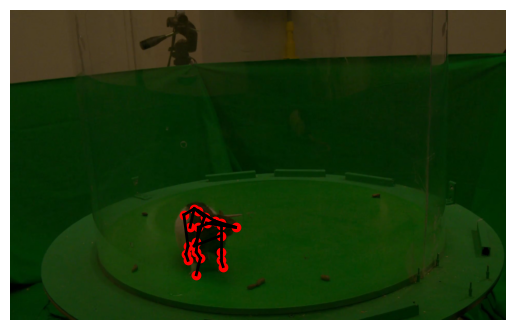

In [59]:
fig = plt.figure()

plt.imshow(np.squeeze(convert_rgb_to_bgr(frame)))

plt.scatter(peaks_all[100,:,0], peaks_all[100,:,1], c='red', marker='o')
for edge in edges:
    start = peaks_all[100,edge[0],:]
    end = peaks_all[100,edge[1],:]
    plt.plot([start[0], end[0]], [start[1],end[1]], 'k-', lw=2)

plt.axis('off')
plt.show()

In [56]:
model_path = '../models/250421_183045.single_instance.n=8280.trt.FP32'
model = OptimizedModel(model_path)
#model_path = '../models/250421_183045.single_instance.n=8280.og'
#model = tf.keras.models.load_model(model_path, compile=False)

#model_path = "../../CLIRB/models/inference_benchmark/250421_183045.single_instance.n=8280/best_model.h5"
#model = tf.keras.models.load_model(model_path, compile=False)

video_path = '../../CLIRB/data/vidSavesSLP/ARID1B_WK1_2022_10_10_M1_mov.mp4'

t0 = perf_counter()

frame = read_frames(video_path, fidxs=[100], grayscale=False)
frame_use = tf.image.convert_image_dtype(frame, tf.float32)

t1 = perf_counter()

with tf.device('/CPU:0'):
    imresized = resize_image(frame_use, 0.5)
    imresized = convert_rgb_to_bgr(imresized)
    imresized = tf.transpose(pad_to_stride(imresized, 8), perm=[0,3,1,2])
    
    #imresized = tf.cast(tf.image.resize(frame, size=[600,960], method='bilinear', preserve_aspect_ratio=False, antialias=False,), tf.float32)
#ready for processing 

t2 = perf_counter()

#disable_preallocation()

with tf.device('/GPU:0'):
    gpu_tensor = tf.Variable(initial_value=tf.zeros((3,3,600,960)))
    #gpu_tensor = tf.cast(tf.Variable(initial_value=tf.zeros((3,600,960, 3))), tf.float32)

model.predict(gpu_tensor) #initialize graph 

t3 = perf_counter()

for i in range(3):
    gpu_tensor[i].assign(imresized) # check how long to load frames onto GPU

t4 = perf_counter()


output = model.predict(gpu_tensor)

t5 = perf_counter()

print(f'Read frame time: {(t1-t0)*1000} msec')
print(f'CPU im preprocessing time: {(t2-t1)*1000} msec')
print(f'Model and gpu tensor initialization time: {(t3-t2)*1000} msec')
print(f'Place preprocessed frames on GPU time: {(t4-t3)*1000} msec')
print(f'Model prediction time: {(t5-t4)*1000} msec')

Read frame time: 118.24769002851099 msec
CPU im preprocessing time: 84.49415600625798 msec
Model and gpu tensor initialization time: 67.28286400903016 msec
Place preprocessed frames on GPU time: 65.37545600440353 msec
Model prediction time: 38.26869698241353 msec


In [47]:
t0 = perf_counter()

trans_output = tf.transpose(output, perm=[0,2,3,1])
peaks, peak_vals = find_global_peaks(trans_output, threshold=0.1, refinement='integral', integral_patch_size=5)
#peaks, peak_vals = find_global_peaks(output, threshold=0.1, refinement='local', integral_patch_size=5)

peaks = peaks * 4
peaks = (peaks / 0.5) + 0.5

t1 = perf_counter()

print(f'Time for transpose and peak finding: {(t1-t0)*1000} msec')

print(peaks.shape)
print(peak_vals.shape)
print(peak_vals[0,:])

Time for transpose and peak finding: 8.34823603508994 msec
(3, 23, 2)
(3, 23)
tf.Tensor(
[0.6339118  0.5368041  1.1660255  0.58179986 0.81315476 0.5869676
 0.34223774 0.689094   0.7945313  0.8706771  0.7607322  0.7228134
 0.5975735  0.5201599  0.6094076  0.75115025 0.28395858 0.23299201
 0.17987819 0.5127524  0.46406844 0.59735376 0.54079014], shape=(23,), dtype=float32)


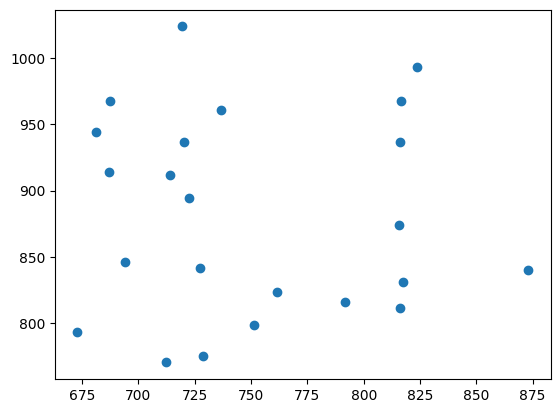

In [48]:
plt.scatter(peaks[0,:,0], peaks[0,:,1])
plt.show()

In [163]:
frame.shape

(1, 1200, 1920, 3)

['Snout', 'EarL', 'EarR', 'SpineF', 'SpineM', 'SpineL', 'TailBase', 'ShoulderL', 'ElbowL', 'WristL', 'HandL', 'ShoulderR', 'ElbowR', 'WristR', 'HandR', 'HipL', 'KneeL', 'AnkleL', 'FootL', 'HipR', 'KneeR', 'AnkleR', 'FootR']
[[ 0  1]
 [ 0  2]
 [ 1  2]
 [ 0  3]
 [ 3  4]
 [ 4  5]
 [ 5  6]
 [ 3  7]
 [ 7  8]
 [ 8  9]
 [ 9 10]
 [ 3 11]
 [11 12]
 [12 13]
 [13 14]
 [ 5 15]
 [15 16]
 [16 17]
 [17 18]
 [ 5 19]
 [19 20]
 [20 21]
 [21 22]]


NameError: name 'peaks' is not defined

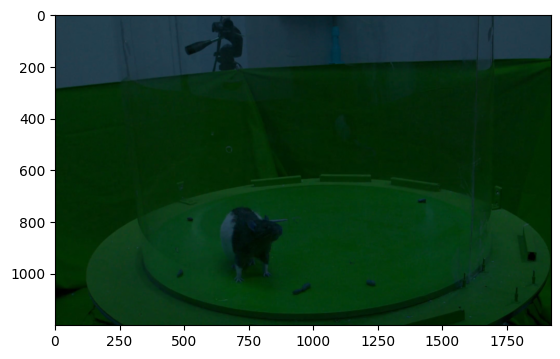

In [57]:

plt.imshow(np.squeeze(frame))

plt.scatter(peaks[0,:,0], peaks[0,:,1], c='red', marker='o')
for edge in edges:
    start = peaks[0,edge[0],:]
    end = peaks[0,edge[1],:]
    plt.plot([start[0], end[0]], [start[1],end[1]], 'k-', lw=2)

plt.axis('off')
plt.show()

In [ ]:
# Single instance layer 
def call(self, data):
        """Predict instance confidence maps and find peaks.

        Args:
            inputs: Full frame images as a `tf.Tensor` of shape
                `(samples, height, width, channels)` or a dictionary with key:
                `"image"`: Full frame images in the same format as above.

        Returns:
            A dictionary of outputs grouped by sample with keys:

            `"instance_peaks"`: The predicted peaks of shape `(samples, 1, nodes, 2)`.
            `"instance_peak_vals": The peak confidence values of shape
            `(samples, 1, nodes)`.

            If the `return_confmaps` attribute is set to `True`, the output will also
            contain a key named `"confmaps"` containing a `tf.Tensor` of shape
            `(samples, output_height, output_width, 1)` containing the confidence maps
            predicted by the model.
        """
        if isinstance(data, dict):
            imgs = data["image"]
        else:
            imgs = data
        imgs = self.preprocess(imgs)
        preds = self.keras_model(imgs)
        offsets = None
        if isinstance(preds, list):
            cms = preds[self.confmaps_ind]
            if self.offsets_ind is not None:
                offsets = preds[self.offsets_ind]
        else:
            cms = preds
        if self.offsets_ind is None:
            peaks, peak_vals = sleap.nn.peak_finding.find_global_peaks(
                cms,
                threshold=self.peak_threshold,
                refinement=self.refinement,
                integral_patch_size=self.integral_patch_size,
            )
        else:
            peaks, peak_vals = sleap.nn.peak_finding.find_global_peaks_with_offsets(
                cms,
                offsets,
                threshold=self.peak_threshold,
            )

        # Adjust for stride and scale.
        peaks = peaks * self.output_stride
        if self.input_scale != 1.0:
            # Note: We add 0.5 here to offset TensorFlow's weird image resizing. This
            # may not always(?) be the most correct approach.
            # See: https://github.com/tensorflow/tensorflow/issues/6720
            peaks = (peaks / self.input_scale) + 0.5

        out = {
            "instance_peaks": tf.expand_dims(peaks, axis=1),
            "instance_peak_vals": tf.expand_dims(peak_vals, axis=1),
        }
        if self.return_confmaps:
            out["confmaps"] = cms
        return out

In [ ]:
# Get skeleton from some mat/slp file
# Use for live plotting skeleton 